### Goal of Project
Predicting a penguin’s species based on its physical measurements is an interesting challenge in data analysis and machine learning. In this blog, we’ll explore the Palmer Penguins dataset, which was collected by Dr. Kristen Gorman and the Palmer Station, to analyze biological measurements of three penguin species in Antarctica. Through data visualization and feature selection, we’ll uncover key insights and build a classification model that achieves perfect accuracy using a carefully chosen set of features. Along the way, we’ll discuss our findings and ensure a reproducible and insightful approach to species classification.
### Loading Data
We will now use the Pandas function to read the CSV and also take a look at the data and the different variables and columns we have in our dataset before we do and data explorations and analysis. 

In [1]:
import pandas as pd

train_url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/train.csv"
train = pd.read_csv(train_url)
train.head()

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,PAL0809,31,Chinstrap penguin (Pygoscelis antarctica),Anvers,Dream,"Adult, 1 Egg Stage",N63A1,Yes,11/24/08,40.9,16.6,187.0,3200.0,FEMALE,9.08458,-24.54903,NaN
1,PAL0809,41,Chinstrap penguin (Pygoscelis antarctica),Anvers,Dream,"Adult, 1 Egg Stage",N74A1,Yes,11/24/08,49.0,19.5,210.0,3950.0,MALE,9.53262,-24.66867,NaN
2,PAL0708,4,Gentoo penguin (Pygoscelis papua),Anvers,Biscoe,"Adult, 1 Egg Stage",N32A2,Yes,11/27/07,50.0,15.2,218.0,5700.0,MALE,8.25540,-25.40075,NaN
3,PAL0708,15,Gentoo penguin (Pygoscelis papua),Anvers,Biscoe,"Adult, 1 Egg Stage",N38A1,Yes,12/3/07,45.8,14.6,210.0,4200.0,FEMALE,7.79958,-25.62618,NaN
4,PAL0809,34,Chinstrap penguin (Pygoscelis antarctica),Anvers,Dream,"Adult, 1 Egg Stage",N65A2,Yes,11/24/08,51.0,18.8,203.0,4100.0,MALE,9.23196,-24.17282,NaN


## Data Cleaning
Our dataset contains numerous variables, including comments and region information, that are not relevant for training our model. Since we will be focusing on variables such as island, culmen length, culmen depth, flipper length, and body mass, we will remove unnecessary columns before proceeding with data exploration, visualization, and model training.
    Let's start by loading the necessary packages for data cleaning, visualization, and model training. We will also convert categorical feature columns like Sex and Island into one-hot encoded 0-1( or true or false) columns using the pd.get_dummies function. Additionally, we can see that Species is a categorical variable, but instead of one-hot encoding, we will use label encoding to convert it into numerical labels: 0 for Adelie, 1 for Chinstrap, and 2 for Gentoo. This transformation will make data visualization and model training much easier.

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC # support vector classifier
from mlxtend.plotting import plot_decision_regions # for visualization later
from sklearn.preprocessing import LabelEncoder

# Encode categorical features and label
le = LabelEncoder()
le.fit(train["Species"])

def prepare_data(df):
    df = df.drop(["studyName", "Sample Number", "Individual ID", "Date Egg", "Comments", "Region", "Stage"], axis=1)
    df = df[df["Sex"] != "."]
    df = df.dropna()
    y = le.transform(df["Species"])
    df = df.drop(["Species"], axis=1)
    # One-hot encode categorical variables
    df =(pd.get_dummies(df)).astype(int)

    return df, y

# Prepare training data
X_train, y_train = prepare_data(train)
X_train.head()


,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Delta 15 N (o/oo),Delta 13 C (o/oo),Island_Biscoe,Island_Dream,Island_Torgersen,Clutch Completion_No,Clutch Completion_Yes,Sex_FEMALE,Sex_MALE
0,40,16,187,3200,9,-24,0,1,0,0,1,1,0
1,49,19,210,3950,9,-24,0,1,0,0,1,0,1
2,50,15,218,5700,8,-25,1,0,0,0,1,0,1
3,45,14,210,4200,7,-25,1,0,0,0,1,1,0
4,51,18,203,4100,9,-24,0,1,0,0,1,0,1


### Visualizing the data
The bar chart below shows the number of penguins of each species on different islands, helping us identify patterns in species distribution. Interestingly, we observe:
- Torgersen Island: Only Adelie penguins are present, with a population of about 30-40 individuals.
- Dream Island: Has both Adelie and Chinstrap penguins, with Chinstrap being the dominant species.
- Biscoe Island: Has both Adelie and Gentoo penguins, with Gentoo having the largest population overall.

Chinstrap penguins are only found on Dream Island, while Gentoo penguins are exclusive to Biscoe Island. Adelie penguins, on the other hand, are the most widespread, appearing on all three islands. Based on this distribution, the island where a penguin is found could be a useful feature for predicting its species.

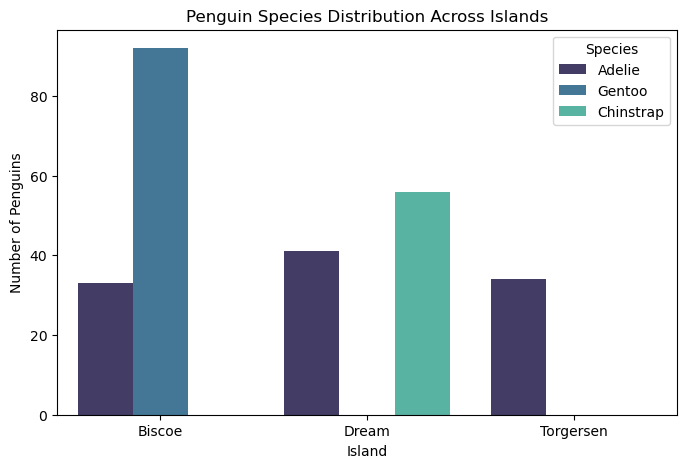

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# Map species labels back to names
species_map = {0: 'Adelie', 1: 'Chinstrap', 2: 'Gentoo'}
species_island_counts = X_train.copy()
species_island_counts["Species"] = [species_map[label] for label in y_train]

# Convert one-hot encoded islands back to a single column
species_island_counts["Island"] = species_island_counts[["Island_Biscoe", "Island_Dream", "Island_Torgersen"]].idxmax(axis=1)
species_island_counts["Island"] = species_island_counts["Island"].str.replace("Island_", "")

# Count number of penguins per species per island
plot_data = species_island_counts.groupby(["Island", "Species"]).size().reset_index(name="Count")

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=plot_data, x="Island", y="Count", hue="Species", palette="mako")
plt.xlabel("Island")
plt.ylabel("Number of Penguins")
plt.title("Penguin Species Distribution Across Islands")
plt.legend(title="Species")
plt.show()

Based on the graph above, we can see that by simply looking at the islands, we can somewhat predict the species of the penguin. This is a good example of a feature that could help predict the species. However, the model would be much more efficient if each island only hosted one species of penguin. Since some islands have more than one species, we might want to explore additional features. For example, if a penguin is on Biscoe Island and has a certain Culmen length and Culmen depth, can we make more accurate predictions based on those measurements? To explore this, we will create a graph to assess whether including Culmen lenght and Culmen depth is a useful feature for predicting the species on each island.

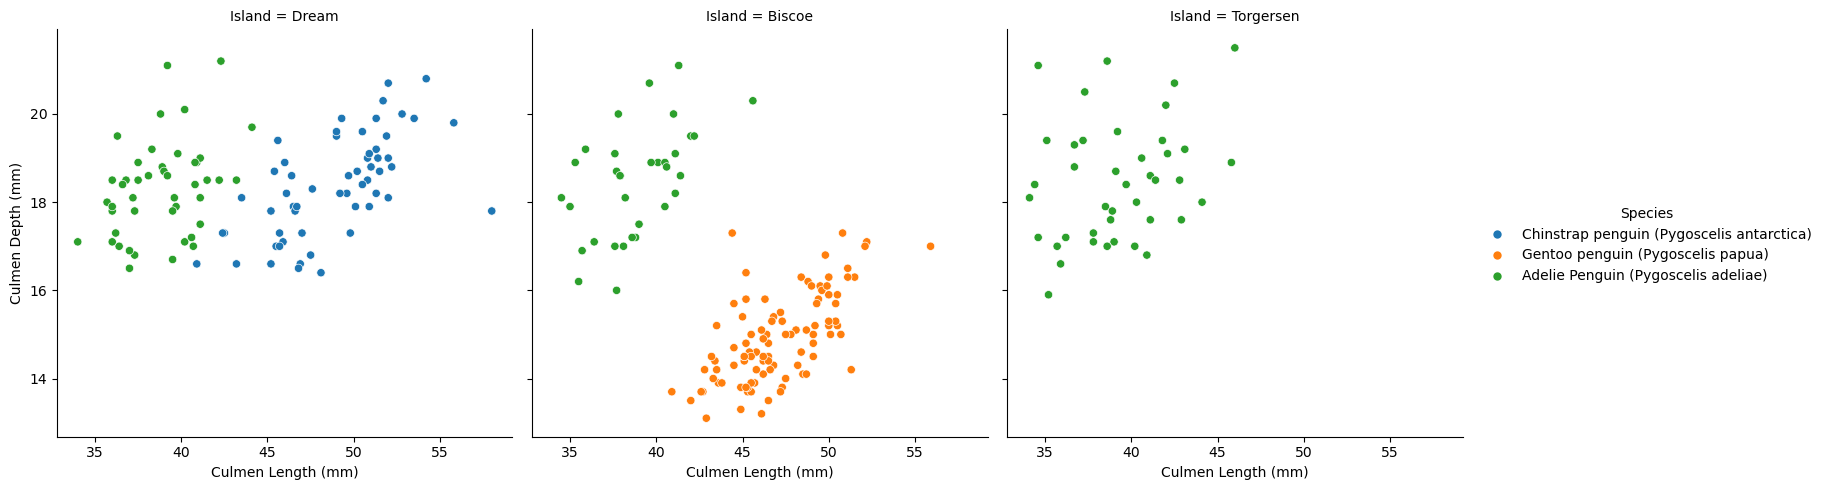

In [ ]:

# Plotting the relationship between Culmen Length and Culmen Depth for each species on each island
sns.relplot(data =train, hue="Species", y = 'Culmen Depth (mm)', x =  'Culmen Length (mm)',col = 'Island')


The graph above looks at the relationship between Culmen Depth (mm) and Culmen Length (mm) for different penguin species, separated by island. Each species is color-coded to highlight patterns in their beak dimensions.
From this graph, we can observe:
- Gentoo penguins (orange) tend to have longer culmen lengths and shallower culmen depths.
- Adelie penguins (green) have moderate culmen lengths and a wide range of culmen depths.
- Chinstrap penguins (blue) have longer culmen lenghts compared to Adelie penguins but exhibit similar culmen Depths.
## Can Culmen Features Help in Classification?
Looking at the separability of species by island:
- Biscoe Island: Gentoo and Adelie penguins are linearly separable, meaning a simple model could classify them effectively based on culmen features.
- Dream Island: Chinstrap and Adelie penguins overlap in culmen depth, making them harder to separate linearly. However, their culmen lengths show some distinction, which could aid classification.
- Torgersen Island: Since only Adelie penguins are found here, culmen features are irrelevant for classification on this island.

This suggests that culmen depth and length can be strong features for classifying species, especially when combined with island location. 
## Exploring Culmen Features in relation to Flipper Lenght


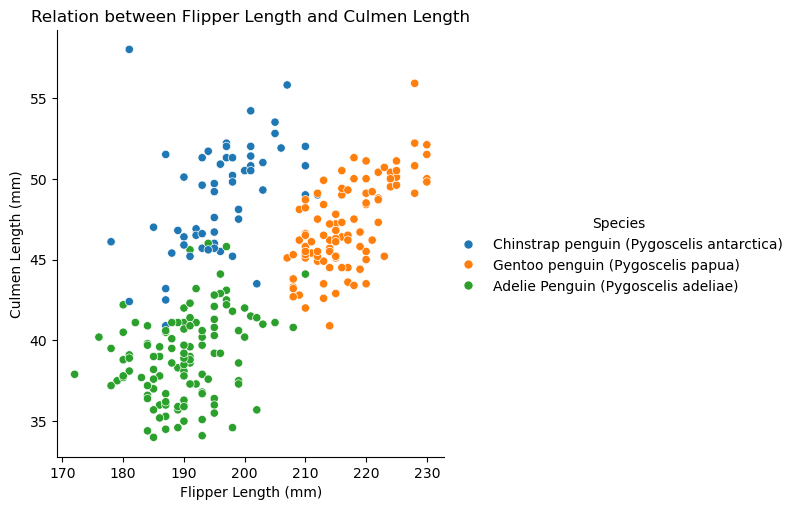

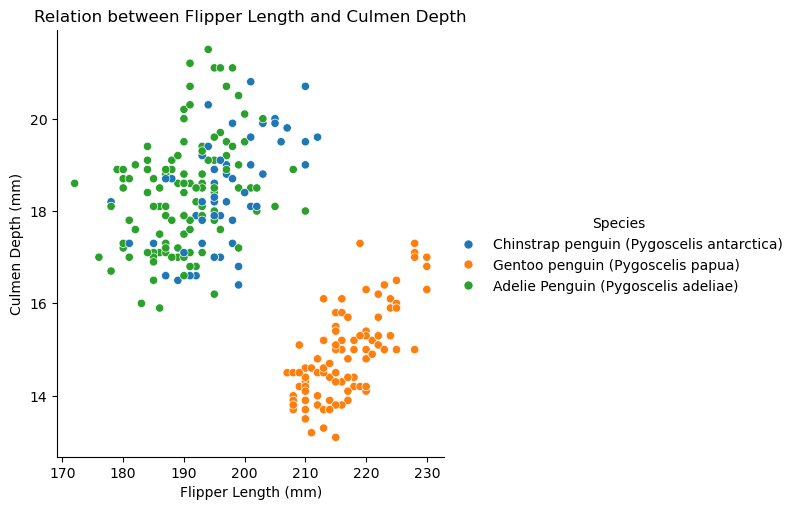

In [4]:
sns.relplot(data = train, y = 'Culmen Length (mm)', x =  'Flipper Length (mm)',  hue = 'Species').set(title='Relation between Flipper Length and Culmen Length')
sns.relplot(data = train, y = 'Culmen Depth (mm)', x =  'Flipper Length (mm)',  hue = 'Species').set(title='Relation between Flipper Length and Culmen Depth')

The first graph explores the relationship between flipper length and culmen length across penguin species. Gentoo penguins have both longer flipper lengths and culmen lengths compared to the other species, making them easily distinguishable. Adelie penguins, in contrast, have shorter values for both features, clustering in the lower-left section of the graph. Chinstrap penguins overlap with Adelie penguins in flipper length but tend to have slightly longer culmen lengths, creating some classification challenges.

The second graph examines the relationship between flipper length and culmen depth. Here, Gentoo penguins are clearly separable from the other two species due to their significantly shallower culmen depths, forming a distinct cluster in the lower section. Howeber the Adelie and Chinstrap penguins overlap a lot more, particularly in flipper length and culmen depth. While Gentoo penguins can be classified easily, distinguishing between Adelie and Chinstrap penguins would be really difficult because of this clustering.

In [ ]:
train.groupby('Species').agg({
    'Flipper Length (mm)': 'mean',
    'Culmen Length (mm)': 'mean',
    'Culmen Depth (mm)': 'mean'
}).reset_index()


,Species,Flipper Length (mm),Culmen Length (mm),Culmen Depth (mm)
0,Adelie Penguin (Pygoscelis adeliae),190.084034,38.970588,18.409244
1,Chinstrap penguin (Pygoscelis antarctica),196.000000,48.826316,18.366667
2,Gentoo penguin (Pygoscelis papua),216.752577,47.073196,14.914433


This code above calculates the mean values of flipper length, culmen length, and culmen depth for each penguin species using the .groupby() function. The table summarizes the average flipper length, culmen length, and culmen depth for each penguin species. Gentoo penguins have the longest flipper and culmen lengths but the shallowest culmen depth. Chinstrap penguins have longer culmen lengths than Adelie penguins but similar culmen depths. Adelie penguins have the shortest flipper and culmen lengths but slightly deeper culmens than Chinstrap. These differences highlight key features that can help classify penguin species.

## Now we are going to chose feature to train our model
By using the combinations function from the itertools package, we generate different combinations of categorical and continuous features. So we will pair categorical variables like Sex and Clutch Completion with continuous variables such as Culmen Length, Culmen Depth, and Flipper Length. This allows us to explore various feature combinations and evaluate which ones might be most useful for accurately classifying the penguin species.

In [ ]:
from itertools import combinations
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
import numpy as np

import warnings
warnings.filterwarnings("ignore")

all_qual_cols = ["Clutch Completion", "Sex", "Island_Biscoe", "Island_Dream", "Island_Torgersen"]
all_quant_cols = ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)', 'Body Mass (g)']

best_score = 0
best_features = None

for qual in all_qual_cols:
    qual_cols = [col for col in X_train.columns if qual in col]  # Ensure categorical features are one-hot encoded
    for pair in combinations(all_quant_cols, 2):
        cols = qual_cols + list(pair)
        
        # Train a logistic regression model to evaluate feature combinations
        model = LogisticRegression(max_iter=1000)  # Increased iterations for better convergence
        scores = cross_val_score(model, X_train[cols], y_train, cv=5, scoring='accuracy')
        
        avg_score = np.mean(scores)
        if avg_score > best_score:
            best_score = avg_score
            best_features = cols

print("Best features:", best_features)


Best features: ['Sex_FEMALE', 'Sex_MALE', 'Culmen Length (mm)', 'Culmen Depth (mm)']


According to itertools, the best features to use are 'Sex_FEMALE', 'Sex_MALE', 'Culmen Length (mm)', and 'Culmen Depth (mm)'. However, we wanted to explore how our model would perform based on our exploration of the island features along with the Culmen features. Thus, we will now reassign these as the best features and use them to train our model.

In [ ]:
#Rearranging Best featrues so that the first two columns are the quantitative columns and the rest are the qualitative columns
best_features = ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Island_Biscoe', 'Island_Dream', 'Island_Torgersen']
best_features

['Culmen Length (mm)',
 'Culmen Depth (mm)',
 'Island_Biscoe',
 'Island_Dream',
 'Island_Torgersen']

## Let us now prepare our Test Dataset

In [ ]:
# Load test data
test_url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/test.csv"
test = pd.read_csv(test_url)

# Prepare test data
X_test, y_test = prepare_data(test)

## Training and evaluating our Model
In the code below, we use a Logistic Regression model and train it on the selected features: ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Island_Biscoe', 'Island_Dream', 'Island_Torgersen']. We then evaluate the accuracy using the LR.score function. Our training accuracy was 99%, and our testing accuracy—measuring how well the model performed on unseen data—was 100%. The confusion matrix confirms that we correctly classified all penguins with no misclassifications. Specifically, our model correctly identified 31 Adelie, 11 Chinstrap, and 26 Gentoo penguins, achieving perfect classification.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

LR = LogisticRegression()
LR.fit(X_train[best_features], y_train)



# Predict on test set
y_pred = LR.predict(X_test[best_features])

# Evaluate the model
score_train = LR.score(X_train[best_features], y_train)
score_test = LR.score(X_test[best_features], y_test)

print("Training Accuracy:", score_train)
print("Test Accuracy:", score_test)

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Training Accuracy: 0.9921875
Test Accuracy: 1.0

Confusion Matrix:
 [[31  0  0]
 [ 0 11  0]
 [ 0  0 26]]


## Plotting our results
This code below helps us visualize the decision regions of our classification model by plotting how different penguin species are separated based on culmen features and island locations. It creates a grid of values for the culmen length and depth, predicts species across the grid. Each subplot represents a different island, showing how the model's decision boundaries change depending on the island feature. This helps us understand how the model differentiates between Adelie, Chinstrap, and Gentoo penguins on each island.

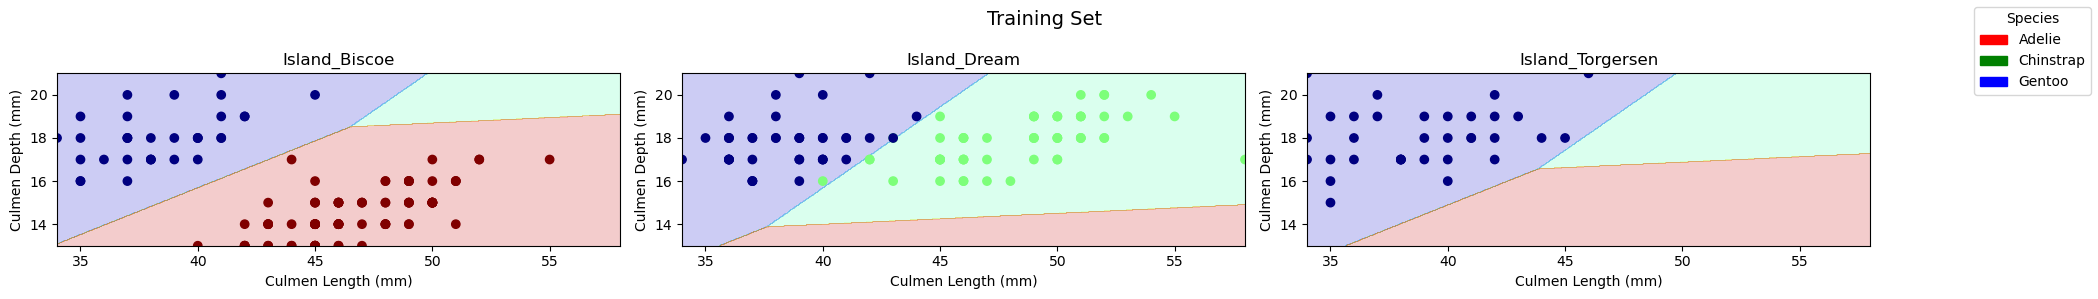

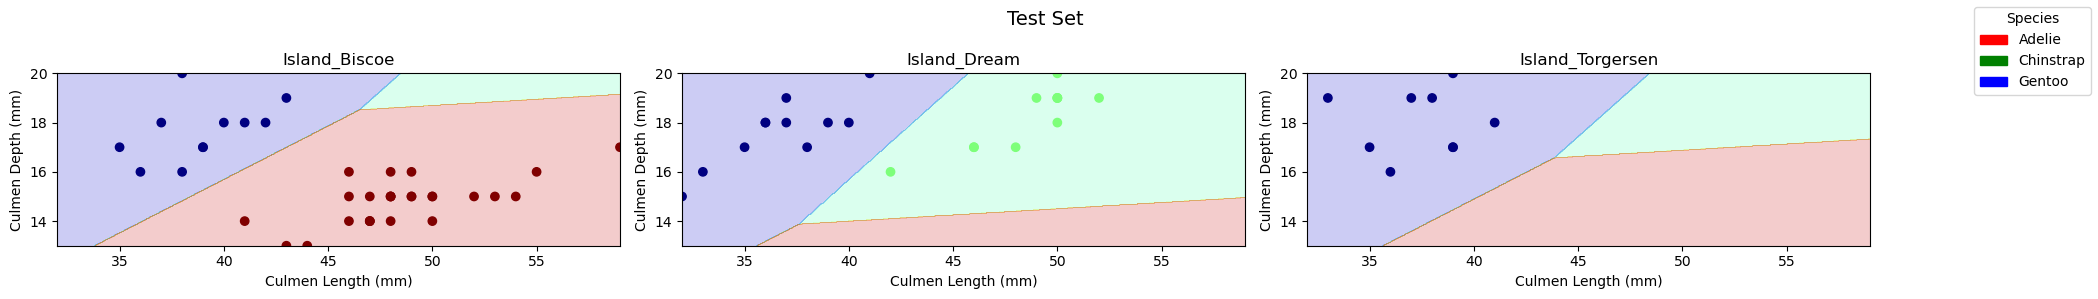

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import Patch

def plot_regions(model, X, y, title):
    
    x0 = X[X.columns[0]]
    x1 = X[X.columns[1]]
    qual_features = X.columns[2:]
    
    fig, axarr = plt.subplots(1, len(qual_features), figsize=(7 * len(qual_features), 3))  # doing this to fit three plots side by side
    fig.suptitle(title, fontsize=14)

    # Create a grid
    grid_x = np.linspace(x0.min(), x0.max(), 501)
    grid_y = np.linspace(x1.min(), x1.max(), 501)
    xx, yy = np.meshgrid(grid_x, grid_y)
    
    XX = xx.ravel()
    YY = yy.ravel()

    if len(qual_features) == 1:
        axarr = [axarr] 

    for i, ax in enumerate(axarr):
        XY = pd.DataFrame({
            X.columns[0]: XX,
            X.columns[1]: YY
        })

        for j in qual_features:
            XY[j] = 0

        XY[qual_features[i]] = 1

        p = model.predict(XY)
        p = p.reshape(xx.shape)
        
        # Use contour plot to visualize the predictions
        ax.contourf(xx, yy, p, cmap="jet", alpha=0.2, vmin=0, vmax=2)

        ix = X[qual_features[i]] == 1
        ax.scatter(x0[ix], x1[ix], c=y[ix], cmap="jet", vmin=0, vmax=2)
        
        ax.set(xlabel=X.columns[0], ylabel=X.columns[1], title=qual_features[i])

    patches = [Patch(color=color, label=spec) for color, spec in zip(["red", "green", "blue"], ["Adelie", "Chinstrap", "Gentoo"])]
    fig.legend(handles=patches, title="Species", loc="upper right")

    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()

# Run function for training and test sets
plot_regions(LR, X_train[best_features], y_train, title="Training Set")
plot_regions(LR, X_test[best_features], y_pred, title="Test Set")
